# Import Packages

In [148]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso,Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import catboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from scipy import stats
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Start with Anxiety Prediction

## Read in  Data

In [149]:
anx_data = pd.read_csv("nick_rr_anx.csv")
anx_data = anx_data.drop("Unnamed: 0", axis = 1)

anx_data_1 = anx_data[anx_data['Gruppenart'] == 1]

anx_data_2 = anx_data[anx_data['Gruppenart'] == 2]
#anx_data.columns

### Look at treatment type 1 first

In [150]:
outcome_1_anx = np.array(anx_data_1['depchange'])
training_data_1_anx = anx_data_1.drop(['depchange','Gruppenart'], axis = 1)

### GLM All Features

In [151]:
all_preds_anx_linear1 = []
all_truth_anx_linear1 = []

kf = KFold(n_splits = 4, shuffle = True, random_state=2)
kf.get_n_splits(training_data_1_anx)
for train_index, test_index in kf.split(training_data_1_anx):
    test_preds = []
    x_train, x_test = training_data_1_anx.iloc[train_index,:], training_data_1_anx.iloc[test_index,:]
    y_train, y_test = np.array(outcome_1_anx)[train_index], np.array(outcome_1_anx)[test_index]
    
    kf_inner = KFold(n_splits = 4, shuffle = True, random_state=3)
    kf_inner.get_n_splits(x_train)
    
    for inner_train, inner_val in kf_inner.split(x_train):
        x_inner_train, x_inner_val = x_train.iloc[inner_train,:], x_train.iloc[inner_val,:]
        y_inner_train, y_inner_val = np.array(y_train)[inner_train], np.array(y_train)[inner_val]
        
        std_lin_model = LinearRegression()
        std_lin_model.fit(x_inner_train,y_inner_train)
        
        outside_preds = std_lin_model.predict(x_test)
        test_preds.append(outside_preds)
    
    test_preds = sum(test_preds)/4
    
    for pred in test_preds:
        all_preds_anx_linear1.append(pred)
    for true in y_test:
        all_truth_anx_linear1.append(true)

Text(0.5, 1.0, 'Linear Model Predicting Depression: R = 0.509')

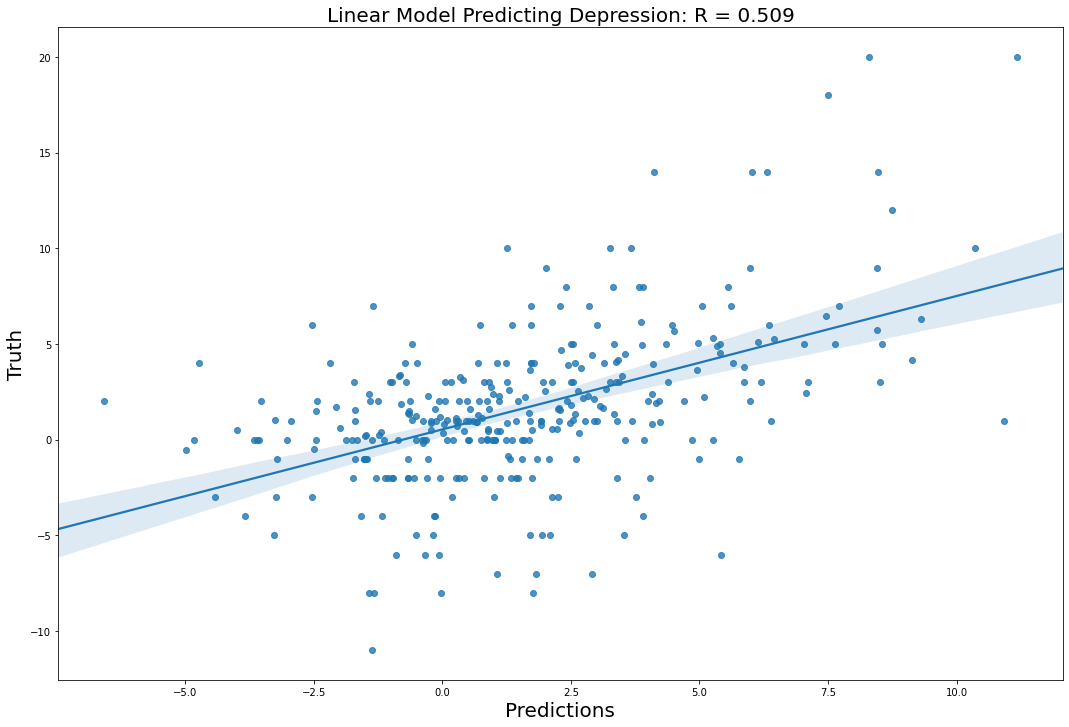

In [152]:
slope, intercept, r_value, p_value, std_err = stats.linregress(all_truth_anx_linear1, all_preds_anx_linear1)
plt.figure(figsize=(18,12))
sns.regplot(all_preds_anx_linear1,all_truth_anx_linear1)
plt.xlabel('Predictions', size = 20)
plt.ylabel('Truth', size = 20)
plt.title(f'Linear Model Predicting Depression: R = {round(r_value,3)}', size = 20)

## GLM with principled feature selection (age, gender, base score, medication)

In [153]:
all_preds_anx_linear1_g = []
all_truth_anx_linear1_g = []

training_data_1_anx_g = training_data_1_anx[['sibar1bt0','sibar1at0','Indikation','GAD7T0']]

kf = KFold(n_splits = 4, shuffle = True, random_state=2)
kf.get_n_splits(training_data_1_anx_g)
for train_index, test_index in kf.split(training_data_1_anx_g):
    test_preds = []
    x_train, x_test = training_data_1_anx_g.iloc[train_index,:], training_data_1_anx_g.iloc[test_index,:]
    y_train, y_test = np.array(outcome_1_anx)[train_index], np.array(outcome_1_anx)[test_index]
    
    kf_inner = KFold(n_splits = 4, shuffle = True, random_state=3)
    kf_inner.get_n_splits(x_train)
    
    for inner_train, inner_val in kf_inner.split(x_train):
        x_inner_train, x_inner_val = x_train.iloc[inner_train,:], x_train.iloc[inner_val,:]
        y_inner_train, y_inner_val = np.array(y_train)[inner_train], np.array(y_train)[inner_val]
        
        std_lin_model = LinearRegression()
        std_lin_model.fit(x_inner_train,y_inner_train)
        
        outside_preds = std_lin_model.predict(x_test)
        test_preds.append(outside_preds)
    
    test_preds = sum(test_preds)/4
    
    for pred in test_preds:
        all_preds_anx_linear1_g.append(pred)
    for true in y_test:
        all_truth_anx_linear1_g.append(true)

Text(0.5, 1.0, 'Linear Model Predicting Depression: R = 0.508')

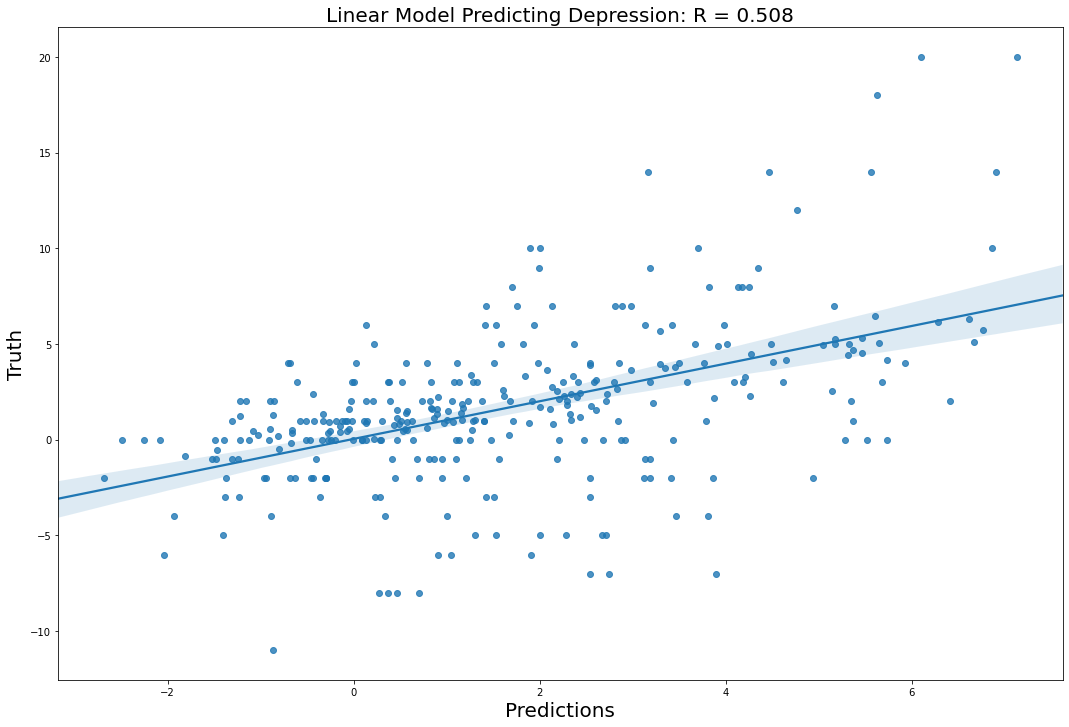

In [154]:
slope, intercept, r_value, p_value, std_err = stats.linregress(all_truth_anx_linear1_g, all_preds_anx_linear1_g)
plt.figure(figsize=(18,12))
sns.regplot(all_preds_anx_linear1_g,all_truth_anx_linear1_g)
plt.xlabel('Predictions', size = 20)
plt.ylabel('Truth', size = 20)
plt.title(f'Linear Model Predicting Depression: R = {round(r_value,3)}', size = 20)

### Combination Model

In [155]:
all_preds_anxiety1 = []
all_truth_anxiety1 = []

kf = KFold(n_splits = 4, shuffle = True, random_state=2)
kf.get_n_splits(training_data_1_anx)
for train_index, test_index in kf.split(training_data_1_anx):
    test_preds = []
    
    """
    Used for tuning within the validation framework.
    This code has been mostly removed or commented out to clean up the notebook.
    """
    #val_preds_anxiety1 = []
    #val_truth_anxiety1 = []
    
    x_train, x_test = training_data_1_anx.iloc[train_index,:], training_data_1_anx.iloc[test_index,:]
    y_train, y_test = np.array(outcome_1_anx)[train_index], np.array(outcome_1_anx)[test_index]
    
    kf_inner = KFold(n_splits = 4, shuffle = True, random_state=3)
    kf_inner.get_n_splits(x_train)
    
    for inner_train, inner_val in kf_inner.split(x_train):
        x_inner_train, x_inner_val = x_train.iloc[inner_train,:], x_train.iloc[inner_val,:]
        y_inner_train, y_inner_val = np.array(y_train)[inner_train], np.array(y_train)[inner_val]
        
        std_lin_model = Lasso(random_state=35)
        std_lin_model.fit(x_inner_train,y_inner_train)
        
        x_mod = RandomForestRegressor(random_state=33)
        x_mod.fit(x_inner_train, y_inner_train)
        
        rf_mod = ElasticNet(random_state=2)
        rf_mod.fit(x_inner_train, y_inner_train)
        
        lgb_mod = Ridge(random_state = 15)
        lgb_mod.fit(x_inner_train, y_inner_train)
        
        mlp_mod = MLPRegressor(random_state=4)
        mlp_mod.fit(x_inner_train, y_inner_train)
        
        gaus_mod = GaussianProcessRegressor(random_state=333)
        gaus_mod.fit(x_inner_train, y_inner_train)
        
        knn_mod = KNeighborsRegressor()
        knn_mod.fit(x_inner_train, y_inner_train)
        
        svr_mod = SVR()
        svr_mod.fit(x_inner_train, y_inner_train)
        
        xgb_mod = XGBRegressor(random_state=331)
        xgb_mod.fit(x_inner_train,y_inner_train)
        
        """
        inside_preds = [std_lin_model.predict(x_inner_val), x_mod.predict(x_inner_val), 
                         rf_mod.predict(x_inner_val), lgb_mod.predict(x_inner_val),
                        mlp_mod.predict(x_inner_val), gaus_mod.predict(x_inner_val),
                        knn_mod.predict(x_inner_val), svr_mod.predict(x_inner_val),
                        xgb_mod.predict(x_inner_val)]
                        
        inside_preds = sum(inside_preds)/len(inside_preds)
        for inner_pred in inside_preds:
            val_preds_anxiety1.append(inner_pred)
        for inner_true in y_inner_val:
            val_truth_anxiety1.append(inner_true)
        """
        
        outside_preds = [std_lin_model.predict(x_test), x_mod.predict(x_test), 
                         rf_mod.predict(x_test), lgb_mod.predict(x_test),
                        mlp_mod.predict(x_test), gaus_mod.predict(x_test),
                        knn_mod.predict(x_test), svr_mod.predict(x_test),
                        xgb_mod.predict(x_test)]
        
        outside_preds = sum(outside_preds)/len(outside_preds)
        
        test_preds.append(outside_preds)
    
    test_preds = sum(test_preds)/4
    
    for pred in test_preds:
        all_preds_anxiety1.append(pred)
    for true in y_test:
        all_truth_anxiety1.append(true)

/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:23:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:23:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:23:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:23:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:23:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:23:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:23:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:23:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[15:23:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[15:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0.5, 1.0, 'Coping and Stress Management Intervention for Depression: R = 0.569')

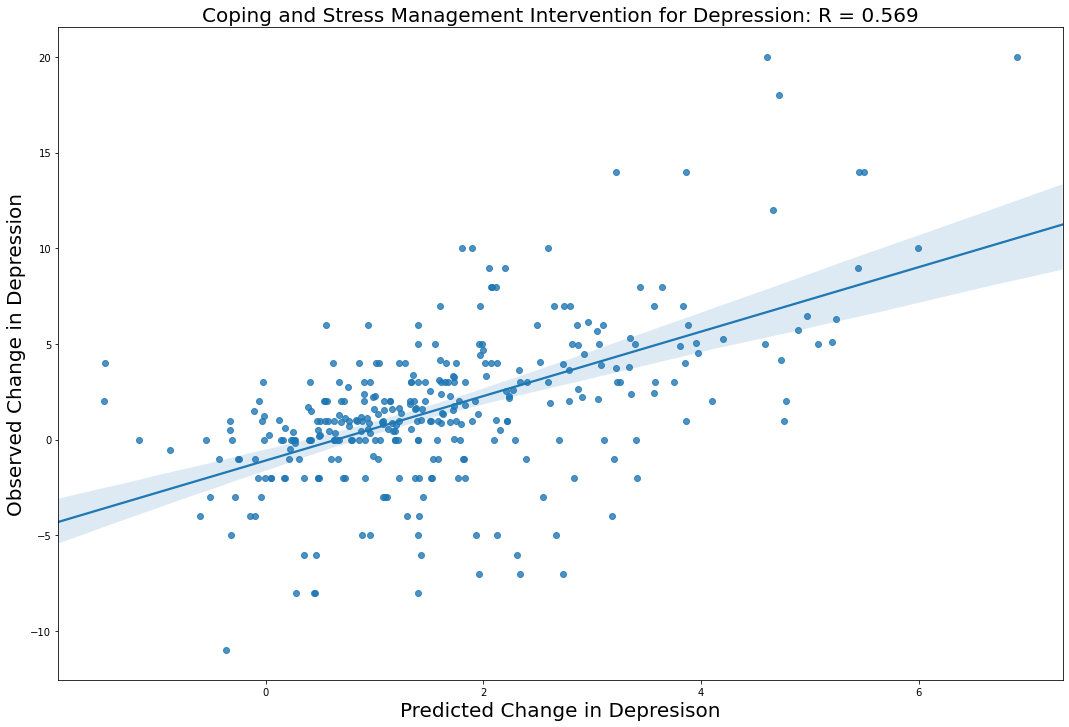

In [156]:
slope, intercept, r_value, p_value, std_err = stats.linregress(all_truth_anxiety1, all_preds_anxiety1)
plt.figure(figsize=(18,12))
sns.regplot(all_preds_anxiety1,all_truth_anxiety1)
plt.xlabel('Predicted Change in Depresison', size = 20)
plt.ylabel('Observed Change in Depression', size = 20)
plt.title(f'Coping and Stress Management Intervention for Depression: R = {round(r_value,3)}', size = 20)

## Now for group 2

In [157]:
outcome_2_anx = np.array(anx_data_2['depchange'])
training_data_2_anx = anx_data_2.drop(['depchange','Gruppenart'], axis = 1)

### GLM

In [158]:
all_preds_anx_linear2 = []
all_truth_anx_linear2 = []

kf = KFold(n_splits = 4, shuffle = True, random_state=2)
kf.get_n_splits(training_data_2_anx)
for train_index, test_index in kf.split(training_data_2_anx):
    test_preds = []
    x_train, x_test = training_data_2_anx.iloc[train_index,:], training_data_2_anx.iloc[test_index,:]
    y_train, y_test = np.array(outcome_2_anx)[train_index], np.array(outcome_2_anx)[test_index]
    
    kf_inner = KFold(n_splits = 4, shuffle = True, random_state=3)
    kf_inner.get_n_splits(x_train)
    
    for inner_train, inner_val in kf_inner.split(x_train):
        x_inner_train, x_inner_val = x_train.iloc[inner_train,:], x_train.iloc[inner_val,:]
        y_inner_train, y_inner_val = np.array(y_train)[inner_train], np.array(y_train)[inner_val]
        
        std_lin_model = LinearRegression()
        std_lin_model.fit(x_inner_train,y_inner_train)
        
        outside_preds = std_lin_model.predict(x_test)
        test_preds.append(outside_preds)
    
    test_preds = sum(test_preds)/4
    
    for pred in test_preds:
        all_preds_anx_linear2.append(pred)
    for true in y_test:
        all_truth_anx_linear2.append(true)

Text(0.5, 1.0, 'Linear Model Predicting Depression: R = 0.483')

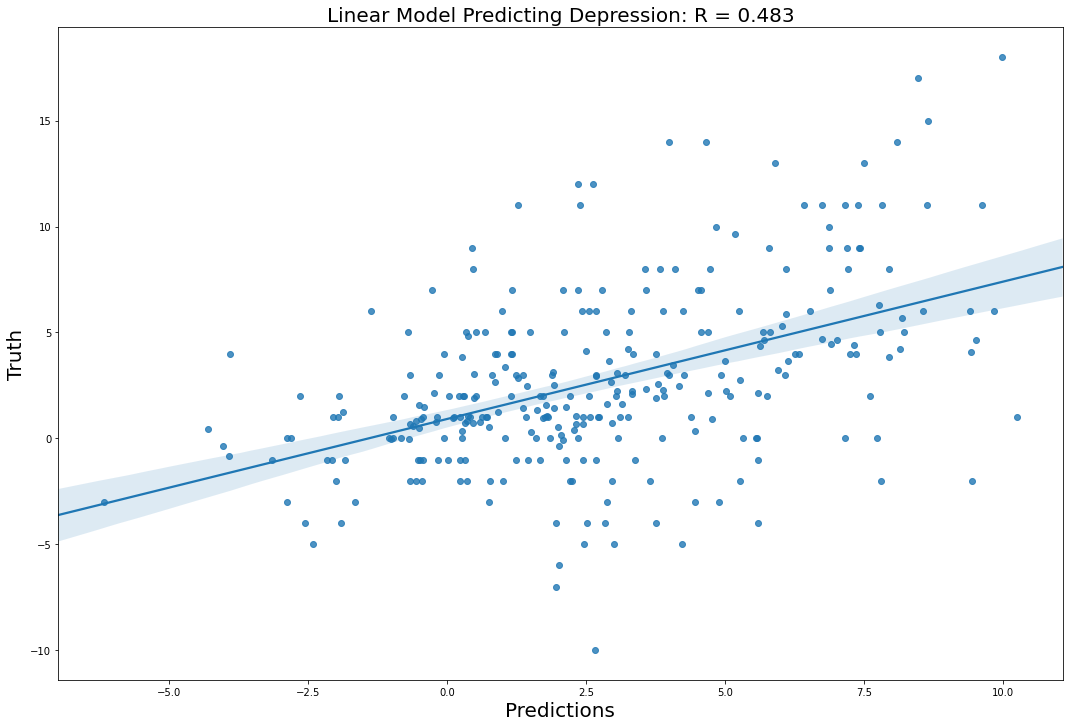

In [159]:
slope, intercept, r_value, p_value, std_err = stats.linregress(all_truth_anx_linear2, all_preds_anx_linear2)
plt.figure(figsize=(18,12))
sns.regplot(all_preds_anx_linear2,all_truth_anx_linear2)
plt.xlabel('Predictions', size = 20)
plt.ylabel('Truth', size = 20)
plt.title(f'Linear Model Predicting Depression: R = {round(r_value,3)}', size = 20)

## GLM with principled feature selection (age, gender, base score, medication)

In [160]:
all_preds_anx_linear2_g = []
all_truth_anx_linear2_g = []

training_data_2_anx_g = training_data_2_anx[['sibar1bt0','sibar1at0','Indikation','GAD7T0']]

kf = KFold(n_splits = 4, shuffle = True, random_state=2)
kf.get_n_splits(training_data_2_anx_g)
for train_index, test_index in kf.split(training_data_2_anx_g):
    test_preds = []
    x_train, x_test = training_data_2_anx_g.iloc[train_index,:], training_data_2_anx_g.iloc[test_index,:]
    y_train, y_test = np.array(outcome_2_anx)[train_index], np.array(outcome_2_anx)[test_index]
    
    kf_inner = KFold(n_splits = 4, shuffle = True, random_state=3)
    kf_inner.get_n_splits(x_train)
    
    for inner_train, inner_val in kf_inner.split(x_train):
        x_inner_train, x_inner_val = x_train.iloc[inner_train,:], x_train.iloc[inner_val,:]
        y_inner_train, y_inner_val = np.array(y_train)[inner_train], np.array(y_train)[inner_val]
        
        std_lin_model = LinearRegression()
        std_lin_model.fit(x_inner_train,y_inner_train)
        
        outside_preds = std_lin_model.predict(x_test)
        test_preds.append(outside_preds)
    
    test_preds = sum(test_preds)/4
    
    for pred in test_preds:
        all_preds_anx_linear2_g.append(pred)
    for true in y_test:
        all_truth_anx_linear2_g.append(true)

Text(0.5, 1.0, 'Linear Model Predicting Depression: R = 0.573')

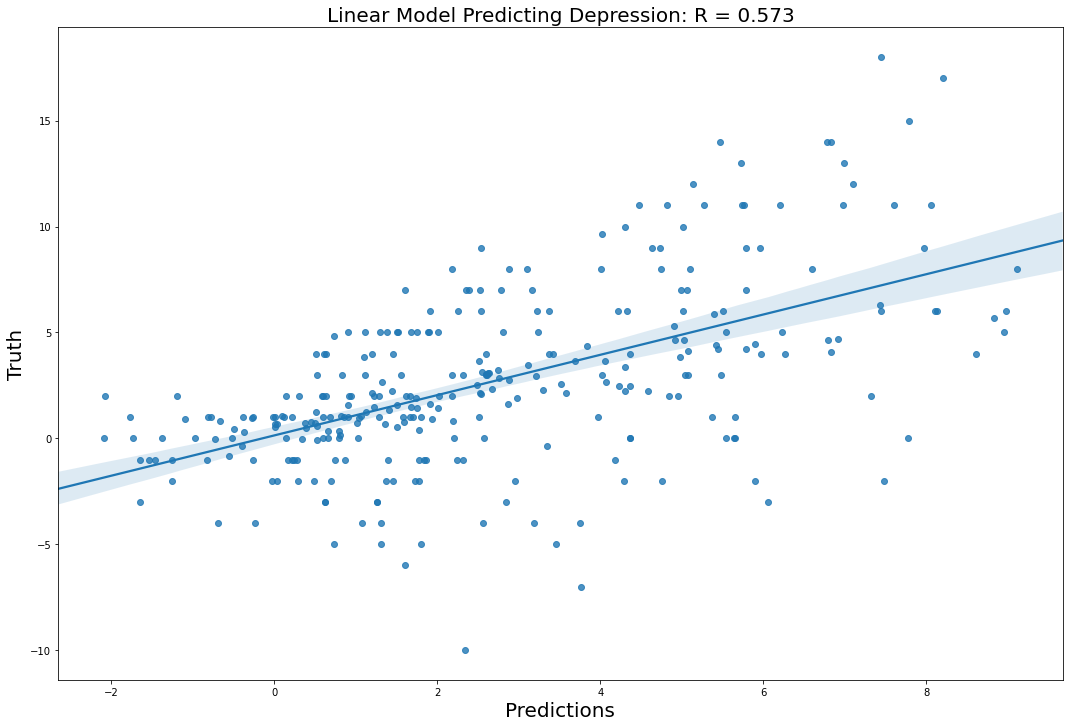

In [161]:
slope, intercept, r_value, p_value, std_err = stats.linregress(all_truth_anx_linear2_g, all_preds_anx_linear2_g)
plt.figure(figsize=(18,12))
sns.regplot(all_preds_anx_linear2_g,all_truth_anx_linear2_g)
plt.xlabel('Predictions', size = 20)
plt.ylabel('Truth', size = 20)
plt.title(f'Linear Model Predicting Depression: R = {round(r_value,3)}', size = 20)

## Combination Model

In [162]:
all_preds_anxiety2 = []
all_truth_anxiety2 = []

kf = KFold(n_splits = 4, shuffle = True, random_state=2)
kf.get_n_splits(training_data_2_anx)
for train_index, test_index in kf.split(training_data_2_anx):
    test_preds = []
    
    """
    Used for tuning within the validation framework.
    This code has been mostly removed or commented out to clean up the notebook.
    """
    #val_preds_anxiety2 = []
    #val_truth_anxiety2 = []
    
    x_train, x_test = training_data_2_anx.iloc[train_index,:], training_data_2_anx.iloc[test_index,:]
    y_train, y_test = np.array(outcome_2_anx)[train_index], np.array(outcome_2_anx)[test_index]
    
    kf_inner = KFold(n_splits = 4, shuffle = True, random_state=3)
    kf_inner.get_n_splits(x_train)
    
    for inner_train, inner_val in kf_inner.split(x_train):
        x_inner_train, x_inner_val = x_train.iloc[inner_train,:], x_train.iloc[inner_val,:]
        y_inner_train, y_inner_val = np.array(y_train)[inner_train], np.array(y_train)[inner_val]
        
        std_lin_model = Lasso(random_state=35)
        std_lin_model.fit(x_inner_train,y_inner_train)
        
        x_mod = RandomForestRegressor(random_state=33)
        x_mod.fit(x_inner_train, y_inner_train)
        
        rf_mod = ElasticNet(random_state=2)
        rf_mod.fit(x_inner_train, y_inner_train)
        
        lgb_mod = Ridge(random_state = 15)
        lgb_mod.fit(x_inner_train, y_inner_train)
        
        mlp_mod = MLPRegressor(random_state=4)
        mlp_mod.fit(x_inner_train, y_inner_train)
        
        gaus_mod = GaussianProcessRegressor(random_state=333)
        gaus_mod.fit(x_inner_train, y_inner_train)
        
        knn_mod = KNeighborsRegressor()
        knn_mod.fit(x_inner_train, y_inner_train)
        
        svr_mod = SVR()
        svr_mod.fit(x_inner_train, y_inner_train)
        
        xgb_mod = XGBRegressor(random_state=331)
        xgb_mod.fit(x_inner_train,y_inner_train)
        
        """
        inside_preds = [std_lin_model.predict(x_inner_val), x_mod.predict(x_inner_val), 
                         rf_mod.predict(x_inner_val), lgb_mod.predict(x_inner_val),
                        mlp_mod.predict(x_inner_val), gaus_mod.predict(x_inner_val),
                        knn_mod.predict(x_inner_val), svr_mod.predict(x_inner_val),
                        xgb_mod.predict(x_inner_val)]
                        
        inside_preds = sum(inside_preds)/len(inside_preds)
        for inner_pred in inside_preds:
            val_preds_anxiety2.append(inner_pred)
        for inner_true in y_inner_val:
            val_truth_anxiety2.append(inner_true)
        """
        
        
        outside_preds = [std_lin_model.predict(x_test), x_mod.predict(x_test), 
                         rf_mod.predict(x_test), lgb_mod.predict(x_test),
                        mlp_mod.predict(x_test), gaus_mod.predict(x_test),
                        knn_mod.predict(x_test), svr_mod.predict(x_test),
                        xgb_mod.predict(x_test)]
        
        outside_preds = sum(outside_preds)/len(outside_preds)
        
        test_preds.append(outside_preds)
    
    test_preds = sum(test_preds)/4
    
    for pred in test_preds:
        all_preds_anxiety2.append(pred)
    for true in y_test:
        all_truth_anxiety2.append(true)

/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:23:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:23:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:23:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:23:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:23:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:23:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:23:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:23:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:23:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:23:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:23:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:23:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:23:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:23:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:23:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:23:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0.5, 1.0, 'Supportive Expressive Therapy for Depression: R = 0.548')

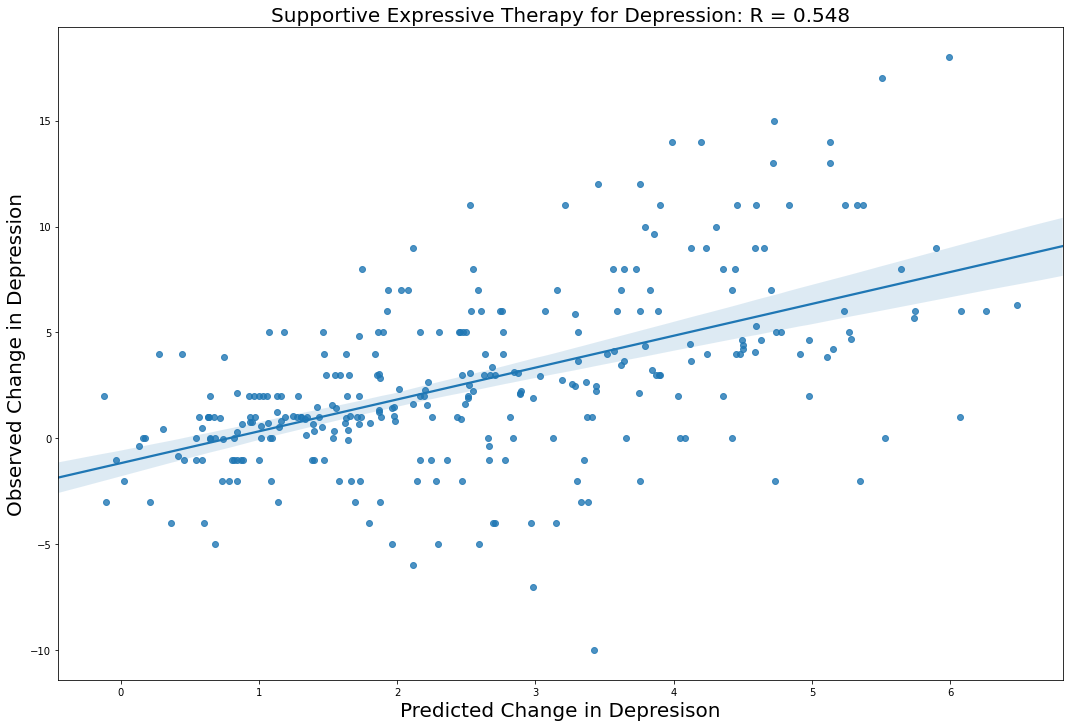

In [163]:
slope, intercept, r_value, p_value, std_err = stats.linregress(all_truth_anxiety2, all_preds_anxiety2)
plt.figure(figsize=(18,12))
sns.regplot(all_preds_anxiety2,all_truth_anxiety2)
plt.xlabel('Predicted Change in Depresison', size = 20)
plt.ylabel('Observed Change in Depression', size = 20)
plt.title(f'Supportive Expressive Therapy for Depression: R = {round(r_value,3)}', size = 20)

# Depression Analysis

In [164]:
dep_data = pd.read_csv("nick_rr_dep.csv")
dep_data = dep_data.drop("Unnamed: 0", axis = 1)

dep_data_1 = dep_data[dep_data['Gruppenart'] == 1]

dep_data_2 = dep_data[dep_data['Gruppenart'] == 2]

## Start with Group 1

## GLM

In [165]:
outcome_1_dep = np.array(dep_data_1['depchange'])
training_data_1_dep = dep_data_1.drop(['depchange','Gruppenart'], axis = 1)

In [166]:
all_preds_dep_linear1 = []
all_truth_dep_linear1 = []

kf = KFold(n_splits = 4, shuffle = True, random_state=2)
kf.get_n_splits(training_data_1_dep)
for train_index, test_index in kf.split(training_data_1_dep):
    test_preds = []
    x_train, x_test = training_data_1_dep.iloc[train_index,:], training_data_1_dep.iloc[test_index,:]
    y_train, y_test = np.array(outcome_1_dep)[train_index], np.array(outcome_1_dep)[test_index]
    
    kf_inner = KFold(n_splits = 4, shuffle = True, random_state=3)
    kf_inner.get_n_splits(x_train)
    
    for inner_train, inner_val in kf_inner.split(x_train):
        x_inner_train, x_inner_val = x_train.iloc[inner_train,:], x_train.iloc[inner_val,:]
        y_inner_train, y_inner_val = np.array(y_train)[inner_train], np.array(y_train)[inner_val]
        
        std_lin_model = LinearRegression()
        std_lin_model.fit(x_inner_train,y_inner_train)
        
        outside_preds = std_lin_model.predict(x_test)
        test_preds.append(outside_preds)
    
    test_preds = sum(test_preds)/4
    
    for pred in test_preds:
        all_preds_dep_linear1.append(pred)
    for true in y_test:
        all_truth_dep_linear1.append(true)

Text(0.5, 1.0, 'Linear Model Predicting Depression: R = 0.446')

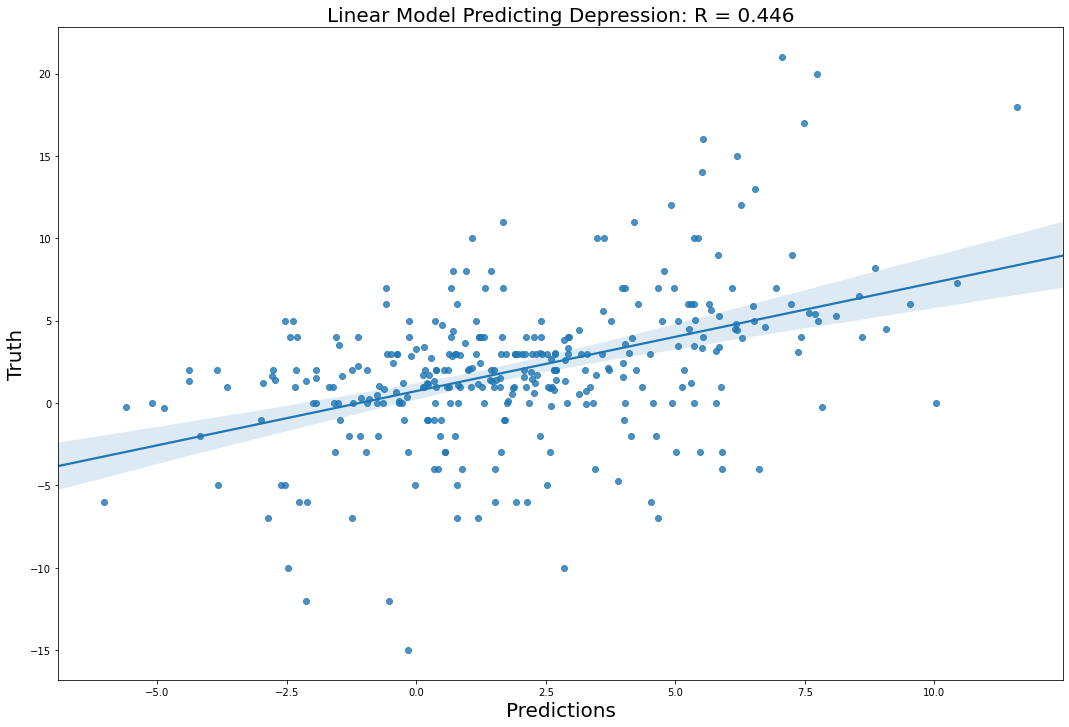

In [167]:
slope, intercept, r_value, p_value, std_err = stats.linregress(all_truth_dep_linear1, all_preds_dep_linear1)
plt.figure(figsize=(18,12))
sns.regplot(all_preds_dep_linear1,all_truth_dep_linear1)
plt.xlabel('Predictions', size = 20)
plt.ylabel('Truth', size = 20)
plt.title(f'Linear Model Predicting Depression: R = {round(r_value,3)}', size = 20)

## GLM with principled feature selection (age, gender, base score, medication)

In [168]:
all_preds_dep_linear1_g = []
all_truth_dep_linear1_g = []

training_data_1_dep_g = training_data_1_dep[['sibar1bt0','sibar1at0','Indikation','PHQ_Dept0']]

kf = KFold(n_splits = 4, shuffle = True, random_state=2)
kf.get_n_splits(training_data_1_dep_g)
for train_index, test_index in kf.split(training_data_1_dep_g):
    test_preds = []
    x_train, x_test = training_data_1_dep_g.iloc[train_index,:], training_data_1_dep_g.iloc[test_index,:]
    y_train, y_test = np.array(outcome_1_dep)[train_index], np.array(outcome_1_dep)[test_index]
    
    kf_inner = KFold(n_splits = 4, shuffle = True, random_state=3)
    kf_inner.get_n_splits(x_train)
    
    for inner_train, inner_val in kf_inner.split(x_train):
        x_inner_train, x_inner_val = x_train.iloc[inner_train,:], x_train.iloc[inner_val,:]
        y_inner_train, y_inner_val = np.array(y_train)[inner_train], np.array(y_train)[inner_val]
        
        std_lin_model = LinearRegression()
        std_lin_model.fit(x_inner_train,y_inner_train)
        
        outside_preds = std_lin_model.predict(x_test)
        test_preds.append(outside_preds)
    
    test_preds = sum(test_preds)/4
    
    for pred in test_preds:
        all_preds_dep_linear1_g.append(pred)
    for true in y_test:
        all_truth_dep_linear1_g.append(true)

Text(0.5, 1.0, 'Linear Model Predicting Depression: R = 0.405')

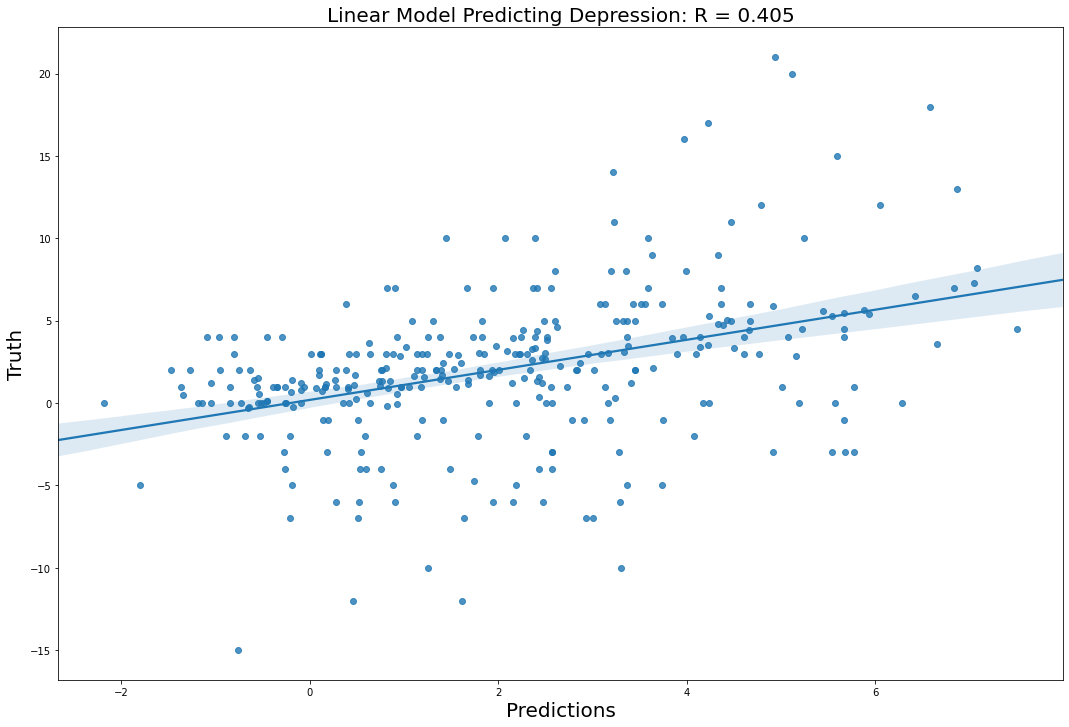

In [169]:
slope, intercept, r_value, p_value, std_err = stats.linregress(all_truth_dep_linear1_g, all_preds_dep_linear1_g)
plt.figure(figsize=(18,12))
sns.regplot(all_preds_dep_linear1_g,all_truth_dep_linear1_g)
plt.xlabel('Predictions', size = 20)
plt.ylabel('Truth', size = 20)
plt.title(f'Linear Model Predicting Depression: R = {round(r_value,3)}', size = 20)

## Now try the combination model

In [170]:
all_preds_dep1 = []
all_truth_dep1 = []

kf = KFold(n_splits = 4, shuffle = True, random_state=2)
kf.get_n_splits(training_data_1_dep)
for train_index, test_index in kf.split(training_data_1_dep):
    test_preds = []
    
    """
    Used for tuning within the validation framework.
    This code has been mostly removed or commented out to clean up the notebook.
    """
    #val_preds_dep1 = []
    #val_truth_dep1 = []
    
    x_train, x_test = training_data_1_dep.iloc[train_index,:], training_data_1_dep.iloc[test_index,:]
    y_train, y_test = np.array(outcome_1_dep)[train_index], np.array(outcome_1_dep)[test_index]
    
    kf_inner = KFold(n_splits = 4, shuffle = True, random_state=3)
    kf_inner.get_n_splits(x_train)
    
    for inner_train, inner_val in kf_inner.split(x_train):
        x_inner_train, x_inner_val = x_train.iloc[inner_train,:], x_train.iloc[inner_val,:]
        y_inner_train, y_inner_val = np.array(y_train)[inner_train], np.array(y_train)[inner_val]
        
        std_lin_model = Lasso(random_state=35)
        std_lin_model.fit(x_inner_train,y_inner_train)
        
        x_mod = RandomForestRegressor(random_state=33)
        x_mod.fit(x_inner_train, y_inner_train)
        
        rf_mod = ElasticNet(random_state=2)
        rf_mod.fit(x_inner_train, y_inner_train)
        
        lgb_mod = Ridge(random_state = 15)
        lgb_mod.fit(x_inner_train, y_inner_train)
        
        mlp_mod = MLPRegressor(random_state=4)
        mlp_mod.fit(x_inner_train, y_inner_train)
        
        gaus_mod = GaussianProcessRegressor(random_state=333)
        gaus_mod.fit(x_inner_train, y_inner_train)
        
        knn_mod = KNeighborsRegressor()
        knn_mod.fit(x_inner_train, y_inner_train)
        
        svr_mod = SVR()
        svr_mod.fit(x_inner_train, y_inner_train)
        
        xgb_mod = XGBRegressor(random_state=331)
        xgb_mod.fit(x_inner_train,y_inner_train)
        
        """
        inside_preds = [std_lin_model.predict(x_inner_val), x_mod.predict(x_inner_val), 
                         rf_mod.predict(x_inner_val), lgb_mod.predict(x_inner_val),
                        mlp_mod.predict(x_inner_val), gaus_mod.predict(x_inner_val),
                        knn_mod.predict(x_inner_val), svr_mod.predict(x_inner_val),
                        xgb_mod.predict(x_inner_val)]
                        
        inside_preds = sum(inside_preds)/len(inside_preds)
        for inner_pred in inside_preds:
            val_preds_dep1.append(inner_pred)
        for inner_true in y_inner_val:
            val_truth_dep1.append(inner_true)
        """
        
        
        outside_preds = [std_lin_model.predict(x_test), x_mod.predict(x_test), 
                         rf_mod.predict(x_test), lgb_mod.predict(x_test),
                        mlp_mod.predict(x_test), gaus_mod.predict(x_test),
                        knn_mod.predict(x_test), svr_mod.predict(x_test),
                        xgb_mod.predict(x_test)]
        
        outside_preds = sum(outside_preds)/len(outside_preds)
        
        test_preds.append(outside_preds)
    
    test_preds = sum(test_preds)/4
    
    for pred in test_preds:
        all_preds_dep1.append(pred)
    for true in y_test:
        all_truth_dep1.append(true)

/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[15:24:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[15:24:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:24:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:24:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[15:24:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[15:24:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:24:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:24:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0.5, 1.0, 'Coping and Stress Management Intervention for Anxiety: R = 0.482')

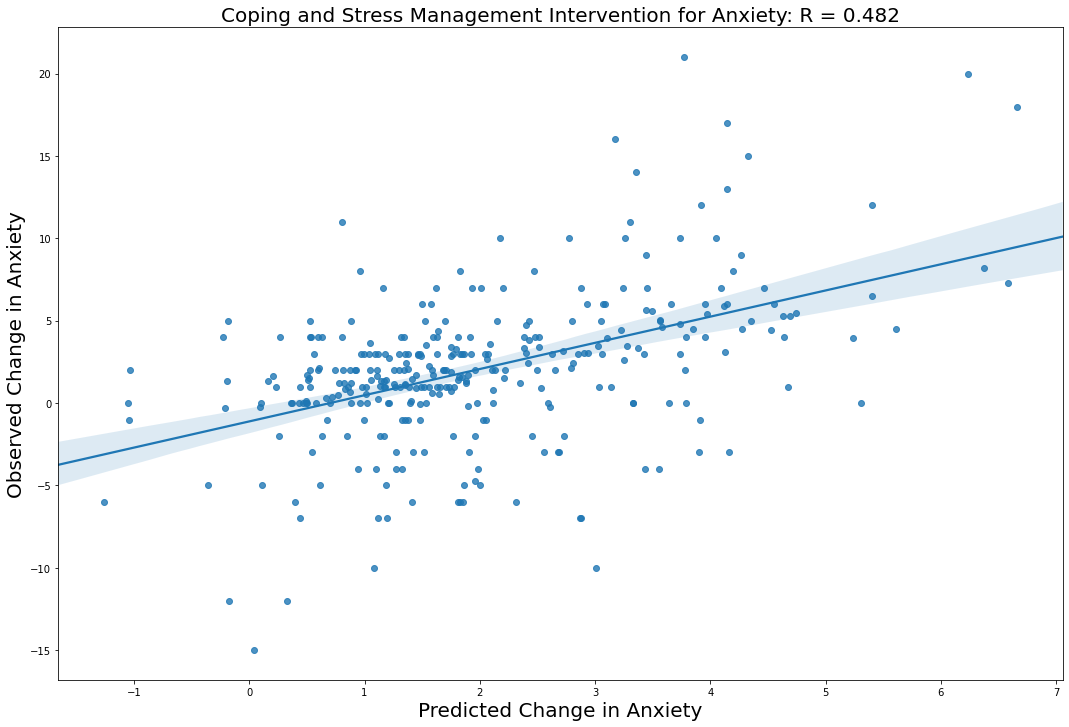

In [171]:
slope, intercept, r_value, p_value, std_err = stats.linregress(all_truth_dep1, all_preds_dep1)
plt.figure(figsize=(18,12))
sns.regplot(all_preds_dep1,all_truth_dep1)
plt.xlabel('Predicted Change in Anxiety', size = 20)
plt.ylabel('Observed Change in Anxiety', size = 20)
plt.title(f'Coping and Stress Management Intervention for Anxiety: R = {round(r_value,3)}', size = 20)

## Group 2 Depression

In [172]:
outcome_2_dep = np.array(dep_data_2['depchange'])
training_data_2_dep = dep_data_2.drop(['depchange','Gruppenart'], axis = 1)

In [173]:
all_preds_dep_linear2 = []
all_truth_dep_linear2 = []

kf = KFold(n_splits = 4, shuffle = True, random_state=2)
kf.get_n_splits(training_data_2_dep)
for train_index, test_index in kf.split(training_data_2_dep):
    test_preds = []
    x_train, x_test = training_data_2_dep.iloc[train_index,:], training_data_2_dep.iloc[test_index,:]
    y_train, y_test = np.array(outcome_2_dep)[train_index], np.array(outcome_2_dep)[test_index]
    
    kf_inner = KFold(n_splits = 4, shuffle = True, random_state=3)
    kf_inner.get_n_splits(x_train)
    
    for inner_train, inner_val in kf_inner.split(x_train):
        x_inner_train, x_inner_val = x_train.iloc[inner_train,:], x_train.iloc[inner_val,:]
        y_inner_train, y_inner_val = np.array(y_train)[inner_train], np.array(y_train)[inner_val]
        
        std_lin_model = LinearRegression()
        std_lin_model.fit(x_inner_train,y_inner_train)
        
        outside_preds = std_lin_model.predict(x_test)
        test_preds.append(outside_preds)
    
    test_preds = sum(test_preds)/4
    
    for pred in test_preds:
        all_preds_dep_linear2.append(pred)
    for true in y_test:
        all_truth_dep_linear2.append(true)

Text(0.5, 1.0, 'Linear Model Predicting Depression: R = 0.417')

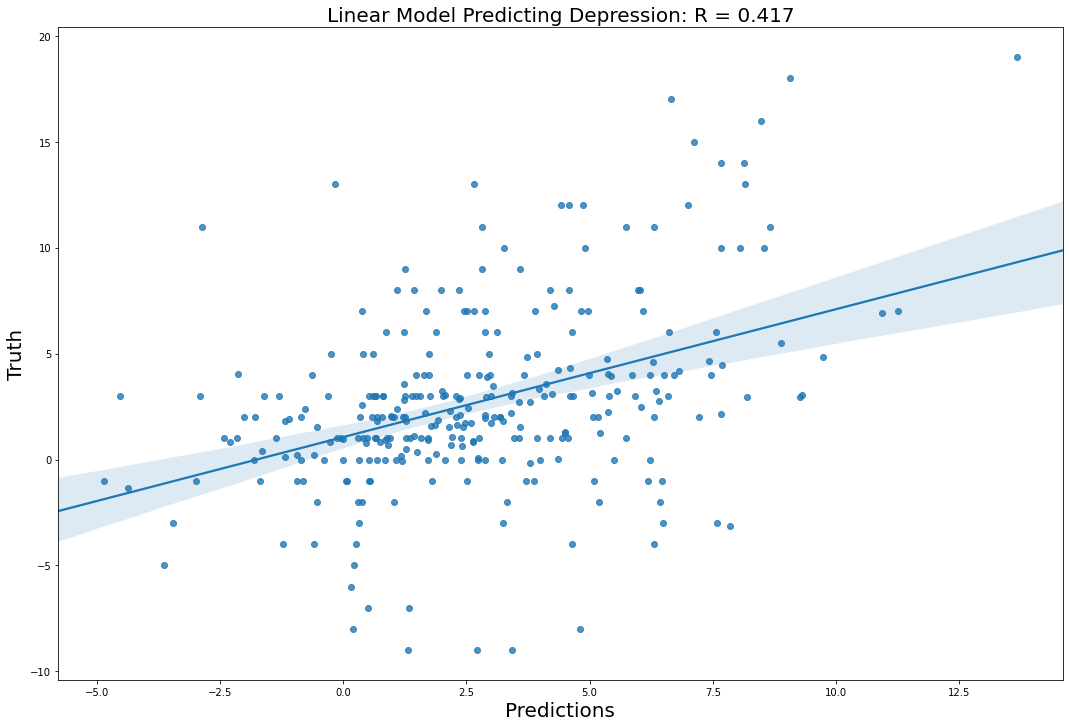

In [174]:
slope, intercept, r_value, p_value, std_err = stats.linregress(all_truth_dep_linear2, all_preds_dep_linear2)
plt.figure(figsize=(18,12))
sns.regplot(all_preds_dep_linear2,all_truth_dep_linear2)
plt.xlabel('Predictions', size = 20)
plt.ylabel('Truth', size = 20)
plt.title(f'Linear Model Predicting Depression: R = {round(r_value,3)}', size = 20)

## GLM with principled feature selection (age, gender, base score, medication)

In [175]:
all_preds_dep_linear2_g = []
all_truth_dep_linear2_g = []

training_data_2_dep_g = training_data_2_dep[['sibar1bt0','sibar1at0','Indikation','PHQ_Dept0']]

kf = KFold(n_splits = 4, shuffle = True, random_state=2)
kf.get_n_splits(training_data_2_dep_g)
for train_index, test_index in kf.split(training_data_2_dep_g):
    test_preds = []
    x_train, x_test = training_data_2_dep_g.iloc[train_index,:], training_data_2_dep_g.iloc[test_index,:]
    y_train, y_test = np.array(outcome_2_dep)[train_index], np.array(outcome_2_dep)[test_index]
    
    kf_inner = KFold(n_splits = 4, shuffle = True, random_state=3)
    kf_inner.get_n_splits(x_train)
    
    for inner_train, inner_val in kf_inner.split(x_train):
        x_inner_train, x_inner_val = x_train.iloc[inner_train,:], x_train.iloc[inner_val,:]
        y_inner_train, y_inner_val = np.array(y_train)[inner_train], np.array(y_train)[inner_val]
        
        std_lin_model = LinearRegression()
        std_lin_model.fit(x_inner_train,y_inner_train)
        
        outside_preds = std_lin_model.predict(x_test)
        test_preds.append(outside_preds)
    
    test_preds = sum(test_preds)/4
    
    for pred in test_preds:
        all_preds_dep_linear2_g.append(pred)
    for true in y_test:
        all_truth_dep_linear2_g.append(true)

Text(0.5, 1.0, 'Linear Model Predicting Depression: R = 0.49')

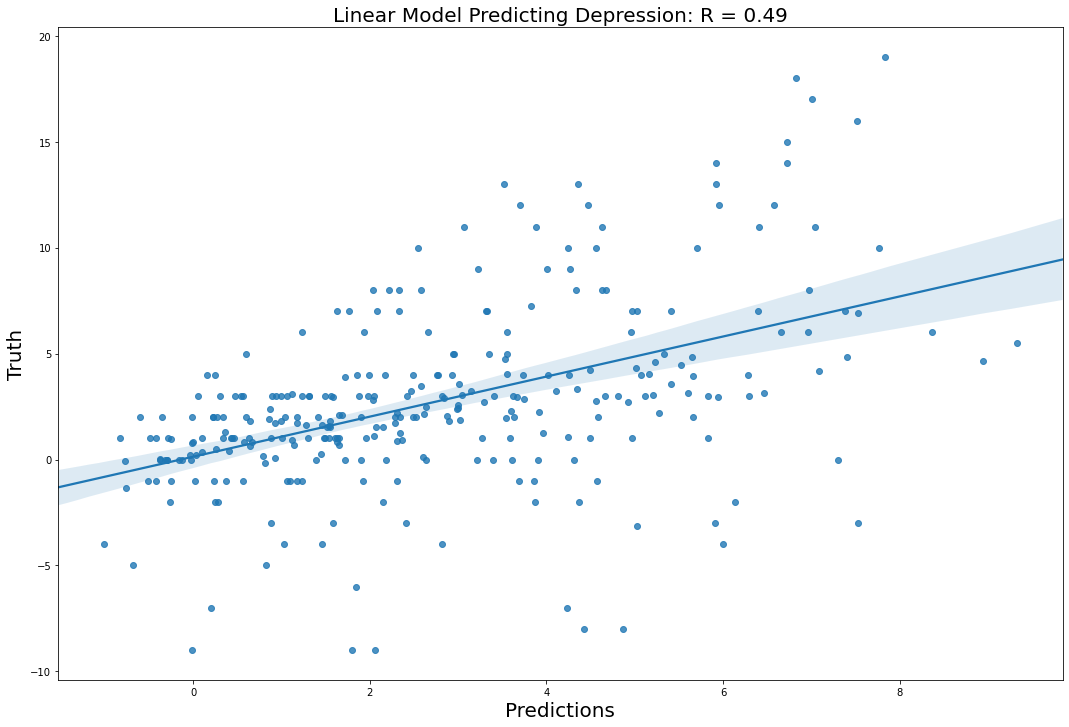

In [176]:
slope, intercept, r_value, p_value, std_err = stats.linregress(all_truth_dep_linear2_g, all_preds_dep_linear2_g)
plt.figure(figsize=(18,12))
sns.regplot(all_preds_dep_linear2_g,all_truth_dep_linear2_g)
plt.xlabel('Predictions', size = 20)
plt.ylabel('Truth', size = 20)
plt.title(f'Linear Model Predicting Depression: R = {round(r_value,3)}', size = 20)

In [177]:
all_preds_dep2 = []
all_truth_dep2 = []

kf = KFold(n_splits = 4, shuffle = True, random_state=2)
kf.get_n_splits(training_data_2_dep)
for train_index, test_index in kf.split(training_data_2_dep):
    test_preds = []
    
    """
    Used for tuning within the validation framework.
    This code has been mostly removed or commented out to clean up the notebook.
    """
    #val_preds_dep2 = []
    #val_truth_dep2 = []
    
    x_train, x_test = training_data_2_dep.iloc[train_index,:], training_data_2_dep.iloc[test_index,:]
    y_train, y_test = np.array(outcome_2_dep)[train_index], np.array(outcome_2_dep)[test_index]
    
    kf_inner = KFold(n_splits = 4, shuffle = True, random_state=3)
    kf_inner.get_n_splits(x_train)
    
    for inner_train, inner_val in kf_inner.split(x_train):
        x_inner_train, x_inner_val = x_train.iloc[inner_train,:], x_train.iloc[inner_val,:]
        y_inner_train, y_inner_val = np.array(y_train)[inner_train], np.array(y_train)[inner_val]
        
        std_lin_model = Lasso(random_state=35)
        std_lin_model.fit(x_inner_train,y_inner_train)
        
        x_mod = RandomForestRegressor(random_state=33)
        x_mod.fit(x_inner_train, y_inner_train)
        
        rf_mod = ElasticNet(random_state=2)
        rf_mod.fit(x_inner_train, y_inner_train)
        
        lgb_mod = Ridge(random_state = 15)
        lgb_mod.fit(x_inner_train, y_inner_train)
        
        mlp_mod = MLPRegressor(random_state=4)
        mlp_mod.fit(x_inner_train, y_inner_train)
        
        gaus_mod = GaussianProcessRegressor(random_state=333)
        gaus_mod.fit(x_inner_train, y_inner_train)
        
        knn_mod = KNeighborsRegressor()
        knn_mod.fit(x_inner_train, y_inner_train)
        
        svr_mod = SVR()
        svr_mod.fit(x_inner_train, y_inner_train)
        
        xgb_mod = XGBRegressor(random_state=331)
        xgb_mod.fit(x_inner_train,y_inner_train)
        
        
        """
        inside_preds = [std_lin_model.predict(x_inner_val), x_mod.predict(x_inner_val), 
                         rf_mod.predict(x_inner_val), lgb_mod.predict(x_inner_val),
                        mlp_mod.predict(x_inner_val), gaus_mod.predict(x_inner_val),
                        knn_mod.predict(x_inner_val), svr_mod.predict(x_inner_val),
                        xgb_mod.predict(x_inner_val)]
                        
        inside_preds = sum(inside_preds)/len(inside_preds)
        for inner_pred in inside_preds:
            val_preds_dep2.append(inner_pred)
        for inner_true in y_inner_val:
            val_truth_dep2.append(inner_true)
        """
        
        
        outside_preds = [std_lin_model.predict(x_test), x_mod.predict(x_test), 
                         rf_mod.predict(x_test), lgb_mod.predict(x_test),
                        mlp_mod.predict(x_test), gaus_mod.predict(x_test),
                        knn_mod.predict(x_test), svr_mod.predict(x_test),
                        xgb_mod.predict(x_test)]
        outside_preds = sum(outside_preds)/len(outside_preds)
        
        test_preds.append(outside_preds)
    
    test_preds = sum(test_preds)/4
    
    for pred in test_preds:
        all_preds_dep2.append(pred)
    for true in y_test:
        all_truth_dep2.append(true)

/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:24:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:24:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:24:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:24:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:24:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:24:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:24:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mnemesur/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

[15:24:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0.5, 1.0, 'Supportive Expressive Therapy for Anxiety: R = 0.477')

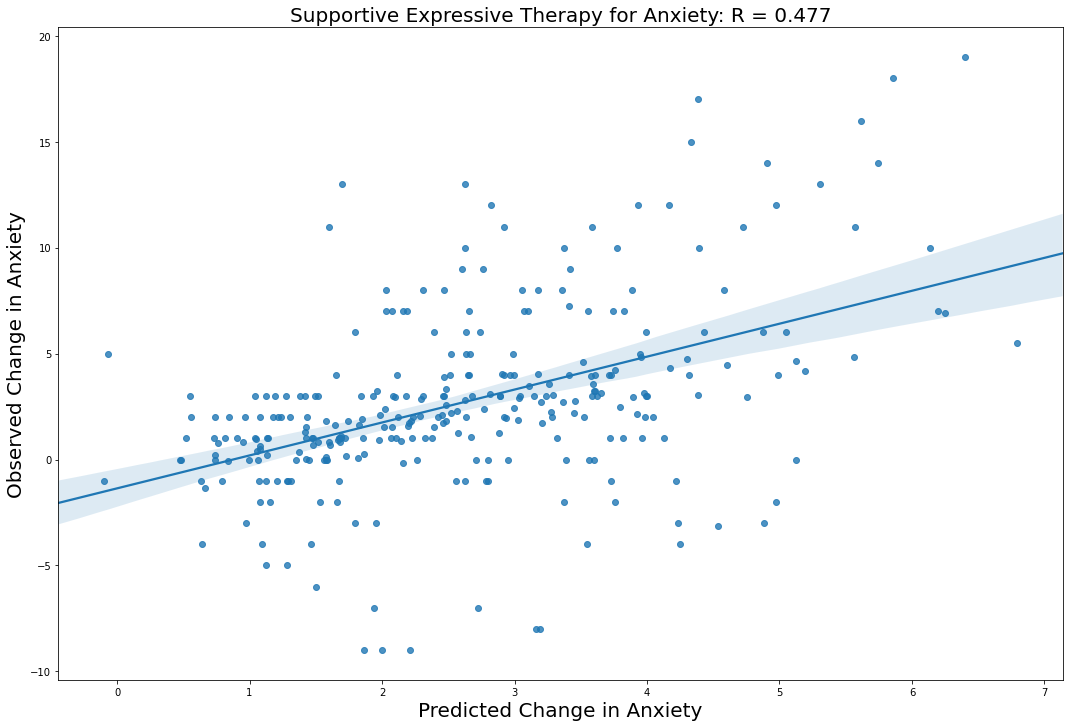

In [178]:
slope, intercept, r_value, p_value, std_err = stats.linregress(all_truth_dep2, all_preds_dep2)
plt.figure(figsize=(18,12))
sns.regplot(all_preds_dep2,all_truth_dep2)
plt.xlabel('Predicted Change in Anxiety', size = 20)
plt.ylabel('Observed Change in Anxiety', size = 20)
plt.title(f'Supportive Expressive Therapy for Anxiety: R = {round(r_value,3)}', size = 20)

ANX
--------------------
0.509 --> 0.569


0.483 --> 0.548


DEP
--------------------
0.446 --> 0.482


0.417 --> 0.477

In [179]:
percent_changes = [(0.569-0.509)/(0.509),
(0.548-0.483)/(0.483),
(0.482-0.446)/(0.446),
(0.477-0.417)/(0.417)]
print(f'Average percent improvement: {round(np.mean(percent_changes)*100,2)}%')

Average percent improvement: 11.93%


### Percent improvement from guided GLM

In [180]:
percent_changes = [(0.569-0.508)/(0.508),
(0.548-0.573)/(0.573),
(0.482-0.405)/(0.405),
(0.477-0.490)/(0.490)]
print(f'Average percent improvement: {round(np.mean(percent_changes)*100,2)}%')

Average percent improvement: 6.0%
